# 0. Importations 

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
print(f"Chemin vers le dossier actuel: \n {os.getcwd()}")
path_main_folder = '/content/drive/My Drive/lyrics_generation/data/'

os.chdir(path_main_folder)
print(f"Chemin vers le dossier actuel: \n {os.getcwd()}")

Chemin vers le dossier actuel: 
 /content
Chemin vers le dossier actuel: 
 /content/drive/My Drive/lyrics_generation/data


In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import configparser as config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import pickle
import torch.nn.functional as F

from argparse import Namespace
import random
import time
import string
import io
import sys, os

!pip install pronouncing
import pronouncing
import nltk
nltk.download('cmudict')

import math  
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Necessary to install language-check
!sudo apt install openjdk-8-jdk
!sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!pip install language-check
import language_check

     |████████████████████████████████| 942kB 7.1MB/s 
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6223 sha256=73010df2cf6a3b5200c3394198b1f73d2c804a39ca2e05f644c661f416b827a9
  Stored in directory: /root/.cache/pip/wheels/81/fd/e8/fb1a226f707c7e20dbed4c43f81b819d279ffd3b0e2f06ee13
Successfully built pronouncing
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jre x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-sour

In [4]:
# Display figures in jupyter notebook
%matplotlib inline

# Ensure reproductbility between models
torch.manual_seed(1)

Define device

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 0. Data Analysis

## 0. A) Exploration

In [0]:
df = pd.read_csv("songdata.csv")
df = df.drop(columns="link")

In [113]:
df.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante","Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [114]:
df.shape

(57650, 3)

In [115]:
df.artist.value_counts()

Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Alabama             187
                   ... 
Zazie                 2
Zed                   1
Zoe                   1
U-Kiss                1
X-Treme               1
Name: artist, Length: 643, dtype: int64

In [0]:
# (Note : Duplicate songs)
len(df.song.unique())
duplicated = df[df.duplicated(subset=['artist','song'])]

In [117]:
duplicated

,artist,song,text
39082,Judy Garland,Look For The Silver Lining,"As I wash my dishes, I'll be following a plan ..."
52998,The Weeknd,Can't Feel My Face,[Verse 1] \nAnd I know she'll be the death of...


In [0]:
# Add songs' total length
df['len_text']= df.text.apply(len)

In [119]:
df.len_text.describe()

count    57650.000000
mean      1179.504892
std        575.705050
min        400.000000
25%        784.000000
50%       1052.000000
75%       1415.000000
max       3997.000000
Name: len_text, dtype: float64

In [120]:
sum(df.len_text)

67998457

In [121]:
#Sample lyrics
print(df.text[142])

I heard, that you're settled down  
That you found a girl and you're, married now  
  
I heard, that your dreams came true  
I guess she gave you things  
I didn't give to you  
  
Old friend, why are you so shy  
Ain't like you to hold back  
Or hide from the light  
  
I hate to turn up out of the blue uninvited but I  
Couldn't stay away I couldn't fight it  
I had hoped you'd see my face  
And that you be reminded that for me it isn't over  
  
Never mind I'll find someone like you  
I wish nothing but the best  
For you too, don't forget me  
I beg, I'll remember you say  
Sometimes it lasts in love  
But sometimes it hurts instead  
Sometimes it lasts in love  
But sometimes it hurts instead yeah  
  
You know how the time flies  
Only yesterday it was the time of our lives  
We were born and raised  
In a summer haze bound by the surprise  
Of our glory days  
  
I hate to turn up out of the blue uninvited but I  
Couldn't stay away I couldn't fight it  
I hoped you'd see my fac

## 0. B) Calculate some characteristics

In [0]:
def get_mean_nb_lines_per_para(x):
  """Calculate the mean number of lines in a paragraph"""
  # Une fin de chanson se traduit par '\n\n'
  # Compter la dernière ligne (+1)
  lignes_par_para = [t.replace('\n\n','').count('\n') + 1 for t in x.split('\n  \n')]
  return math.ceil(np.mean(lignes_par_para))

def get_lines(x):
  """Return a list of the lines of a song"""
  #Split in lines
  lines = x.split('\n')
  # Remove trailing spaces
  r = [j.strip() for j in lines]
  # Remove empty lines
  return [x for x in r if len(x)>0]

def get_mean_len_line(x):
  """Calculate average length of a line"""
  # Calculate len of lines
  len_lines= [len(r) for r in x]
  # Return mean length
  return math.ceil(np.mean(len_lines))

def get_mean_nb_words_per_line(x):
  """Calculate average nb of words of a line"""
  # Calculate len of lines
  words_list = [j.split(" ") for j in x]
  nb_words= [len(r) for r in words_list]
  # Return mean length
  return math.ceil(np.mean(nb_words))

def get_nb_repeated_lines(x):
  """Calculate the number of lines that are repeated"""
  l = [normalize(j) for j in x]
  d = dict(Counter(l))
  return sum(1 for i in d.values() if i >= 2)

def normalize(text):
  "Custom function to remove punctuation and lower text"
  text= "".join(v for v in text if v not in string.punctuation)
  return text.lower()

def get_nb_words(x):
  """Calculate nb of words in a song (x is the list of lines)"""
  # Calculate len of lines
  words_list = [j.strip().split(" ") for j in x]
  nb_words= [len(r) for r in words_list]
  return sum(nb_words)

In [0]:
df['nb_songs']=df.groupby('artist').count()['song']
df['lines']=df.text.apply(get_lines)
df['nb_paragraphes']= df.text.apply(lambda x: x.count('\n  \n')+1)
df['mean_nb_lines_per_para'] = df.text.apply(get_mean_nb_lines_per_para)
df['nb_lines']=df.lines.apply(len)
df['mean_len_line']= df.lines.apply(get_mean_len_line)
df['nb_repeated_lines']= df.lines.apply(get_nb_repeated_lines)
df['mean_nb_words_per_line']= df.lines.apply(get_mean_nb_words_per_line)

In [124]:
# Simple check
df.iloc[142,:]

artist                                                                Adele
song                                                       Someone Like You
text                      I heard, that you're settled down  \nThat you ...
len_text                                                               1836
nb_songs                                                                NaN
lines                     [I heard, that you're settled down, That you f...
nb_paragraphes                                                           12
mean_nb_lines_per_para                                                    4
nb_lines                                                                 46
mean_len_line                                                            37
nb_repeated_lines                                                         7
mean_nb_words_per_line                                                    8
Name: 142, dtype: object

Create a dataframe with artists as index

In [21]:
# Get mean values for each artist
artists_df = df.groupby('artist').mean()
artists_df['nb_songs'] = df.groupby('artist').count()['song']
artists_df = artists_df.astype(int)
artists_df.head()

,len_text,nb_songs,nb_paragraphes,mean_nb_lines_per_para,nb_lines,mean_len_line,nb_repeated_lines,mean_nb_words_per_line
artist,,,,,,,,
'n Sync,1432,93,7,8,45,29,6,6
ABBA,1340,113,6,7,38,32,7,7
Ace Of Base,1288,74,8,6,42,27,6,6
Adam Sandler,1475,70,7,13,41,33,2,6
Adele,1523,54,7,6,46,31,8,7


In [22]:
# Number of artists
len(artists_df.index)

643

In [23]:
artists_df.describe()

,len_text,nb_songs,nb_paragraphes,mean_nb_lines_per_para,nb_lines,mean_len_line,nb_repeated_lines,mean_nb_words_per_line
count,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000
mean,1227.167963,89.657854,5.782271,9.897356,35.671851,31.451011,4.270607,6.483670
std,453.476903,54.689192,2.113419,5.650686,11.274248,4.254594,1.888197,0.922696
min,469.000000,1.000000,1.000000,3.000000,16.000000,20.000000,0.000000,4.000000
25%,958.500000,41.000000,4.500000,6.000000,28.000000,29.000000,3.000000,6.000000
50%,1110.000000,86.000000,6.000000,8.000000,33.000000,31.000000,4.000000,6.000000
75%,1337.000000,141.000000,7.000000,12.000000,40.000000,33.000000,5.000000,7.000000
max,3134.000000,191.000000,24.000000,46.000000,75.000000,57.000000,13.000000,12.000000


Choose artist to duplicate his style

In [0]:
# Get artists with most songs
#artists_df.sort_values(by=['nb_songs'], ascending=False).iloc[100:150,:]

In [0]:
# Some artists with lots of songs
artists = ['Elton John','Michael Jackson','Red Hot Chili Peppers', 'The Beatles', 'Queen', 'Mariah Carey', 'Britney Spears', 'Miley Cyrus']

In [26]:
artists_df.loc[artists,]

,len_text,nb_songs,nb_paragraphes,mean_nb_lines_per_para,nb_lines,mean_len_line,nb_repeated_lines,mean_nb_words_per_line
artist,,,,,,,,
Elton John,1017,175,5,7,27,34,3,7
Michael Jackson,1484,176,9,6,48,29,7,6
Red Hot Chili Peppers,1311,173,8,8,42,28,6,6
The Beatles,919,178,5,6,28,31,5,6
Queen,1235,163,5,10,37,30,3,6
Mariah Carey,1551,159,8,8,54,26,7,5
Britney Spears,1418,158,9,6,49,26,8,6
Miley Cyrus,1513,147,9,7,49,29,7,6


Evaluate parameters's std for chosen artists

In [0]:
artists_std = df.groupby('artist').std()

In [28]:
artists_std.describe()

,len_text,nb_songs,nb_paragraphes,mean_nb_lines_per_para,nb_lines,mean_len_line,nb_repeated_lines,mean_nb_words_per_line
count,639.000000,0.0,639.000000,639.000000,639.000000,639.000000,639.000000,639.000000
mean,433.882946,NaN,3.660423,9.648318,13.699595,7.200135,3.377558,1.484262
std,166.415804,NaN,2.103006,5.781015,4.956040,1.845670,0.965796,0.381786
min,23.334524,NaN,0.000000,0.000000,1.414214,0.707107,0.000000,0.000000
25%,328.437384,NaN,2.739772,5.661232,10.467930,6.107262,2.745934,1.260207
50%,389.883439,NaN,3.208837,8.832752,12.737054,7.023769,3.279342,1.451049
75%,490.807553,NaN,4.064897,12.511770,15.650522,8.006069,3.889059,1.654932
max,1154.937661,NaN,32.201426,39.715656,41.055180,23.891421,9.131258,5.683309


In [29]:
artists_std.loc[artists,]

,len_text,nb_songs,nb_paragraphes,mean_nb_lines_per_para,nb_lines,mean_len_line,nb_repeated_lines,mean_nb_words_per_line
artist,,,,,,,,
Elton John,365.567024,NaN,2.955199,7.591491,11.035792,8.238693,3.339449,1.668150
Michael Jackson,656.260869,NaN,4.792090,5.534282,25.642487,6.901155,4.887856,1.409753
Red Hot Chili Peppers,463.726257,NaN,4.696080,9.135358,15.039999,7.348780,4.349197,1.483407
The Beatles,263.633482,NaN,2.756507,5.054646,9.345490,7.882935,3.317003,1.576193
Queen,411.932033,NaN,3.130357,10.139170,12.655139,5.825760,2.707132,1.259787
Mariah Carey,752.506341,NaN,5.083453,7.949311,28.190731,5.916652,5.066794,1.179226
Britney Spears,578.178219,NaN,4.355800,4.882164,22.335989,5.919782,5.558775,1.360709
Miley Cyrus,532.823456,NaN,3.713019,8.218506,18.351551,8.427366,4.806817,1.675468


We can choose **The Beatles** : a lot of songs + songs not too much different

In [0]:
beatles_df = df[df.artist== "The Beatles"]

In [31]:
print("Total number of lines is")
print(sum(beatles_df.nb_lines))
print("Total number of words is")
print(sum(beatles_df.lines.apply(get_nb_words)))
print("Total number of characters is")
sum(beatles_df.len_text)

Total number of lines is
4989
Total number of words is
30879
Total number of characters is


163652

In [231]:
# Mean number of words in a song
print(np.mean(beatles_df.lines.apply(get_nb_words)))

173.47752808988764


## 0. C) Plot characteristics

Plot characteristics for one artist

Text(0.5, 1.0, 'Characteristics for The Beatles songs')

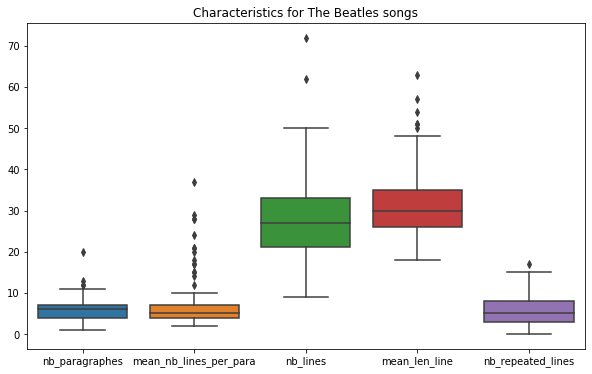

In [32]:
plt.figure(figsize=(10, 6))
artist = 'The Beatles'
sns.boxplot(data=df[df.artist==artist].iloc[:,5:-1])
plt.title("Characteristics for {} songs".format(artist))

Compare one characteristic between artists

In [0]:
def get_topk(k, df):
  """Get the top k artists with the most songs"""
  l = df.artist.value_counts()
  return l[:k].index.tolist()

Text(0.5, 1.0, 'Compare artists on nb_paragraphes')

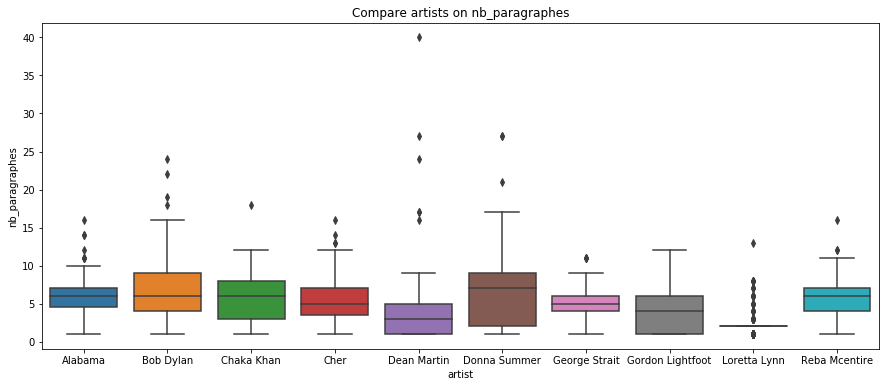

In [39]:
plt.figure(figsize=(15, 6))
characteristic = "nb_paragraphes"
artists = get_topk(10, df)
df_to_show = df[df.artist.isin(artists)]
sns.boxplot(y=df[characteristic], x=df_to_show.artist)
plt.title("Compare artists on {}".format(characteristic))

In [37]:
# Mean values
print("Mean value for nb paragraphes", round(np.mean(artists_df.nb_paragraphes)))
print("Mean value for length of song", round(np.mean(artists_df.len_text)))
print("Mean value for nb lines", round(np.mean(artists_df.nb_lines)))
print("Mean value for nb of lines in paragraph", round(np.mean(artists_df.mean_nb_lines_per_para)))
print("Mean value for nb words in a line", round(np.mean(artists_df.mean_nb_words_per_line)))

Mean value for nb paragraphes 6
Mean value for length of song 1227
Mean value for nb lines 36
Mean value for nb of lines in paragraph 10
Mean value for nb words in a line 6


Plot one characteristic

Text(0, 0.5, 'Number of songs')

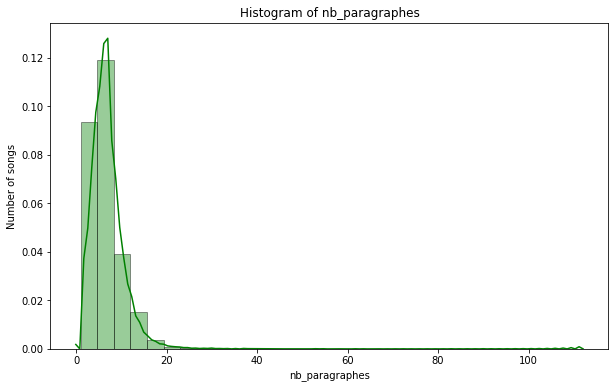

In [40]:
plt.figure(figsize=(10, 6))
characteristic = 'nb_paragraphes'
sns.distplot(df[characteristic], hist=True, kde=True, 
             bins=30, color = 'green',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of {}'.format(characteristic))
plt.xlabel(characteristic)
plt.ylabel('Number of songs')

Compare all characteristics between all artists

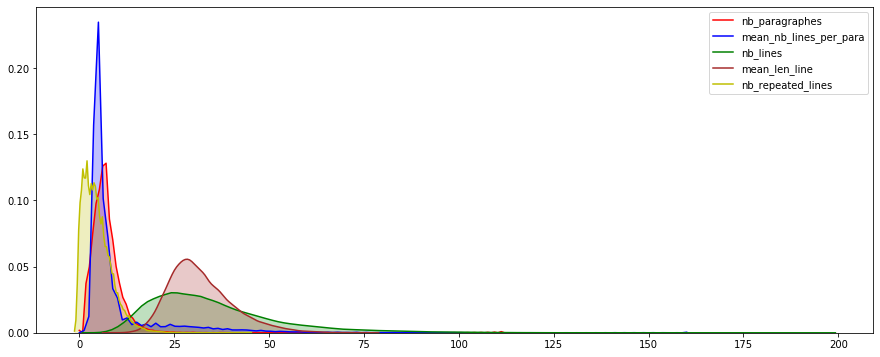

In [41]:
plt.figure(figsize=(15, 6))
p1=sns.kdeplot(df['nb_paragraphes'], shade=True, color="r")
p1=sns.kdeplot(df['mean_nb_lines_per_para'], shade=True, color="b")
p1=sns.kdeplot(df['nb_lines'], shade=True, color="g")
p1=sns.kdeplot(df['mean_len_line'], shade=True, color="brown")
p1=sns.kdeplot(df['nb_repeated_lines'], shade=True, color="y")

The number of paragraphes and the mean number of lines seem to be common to most songs, with values respectively around 6 and 10

Text(0.5, 1.0, 'Compare the top 50 artists on all characteristics')

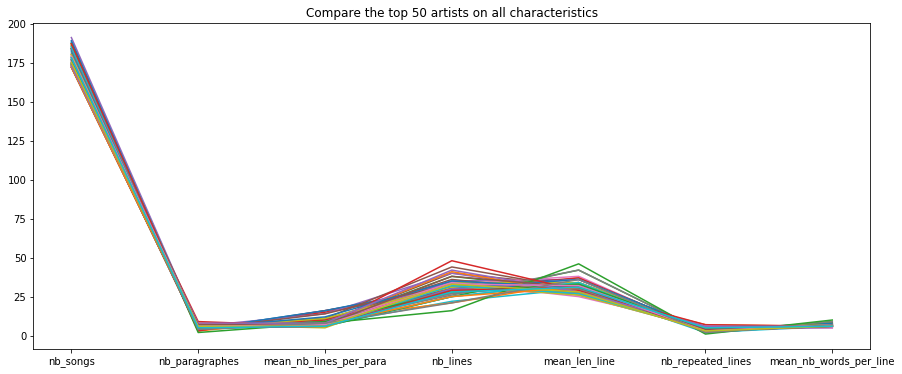

In [44]:
plt.figure(figsize=(15, 6))
# For the top k artists
topk = 50
artists = get_topk(topk, df)
plot_artists_to_show = artists_df[artists_df.index.isin(artists)]
plt.plot(plot_artists_to_show.drop(columns=['len_text']).T)
#plt.legend(plot_artists_to_show.columns)
plt.title("Compare the top {} artists on all characteristics".format(topk))

Text(0.5, 1.0, 'Compare the top 10 artists on all characteristics')

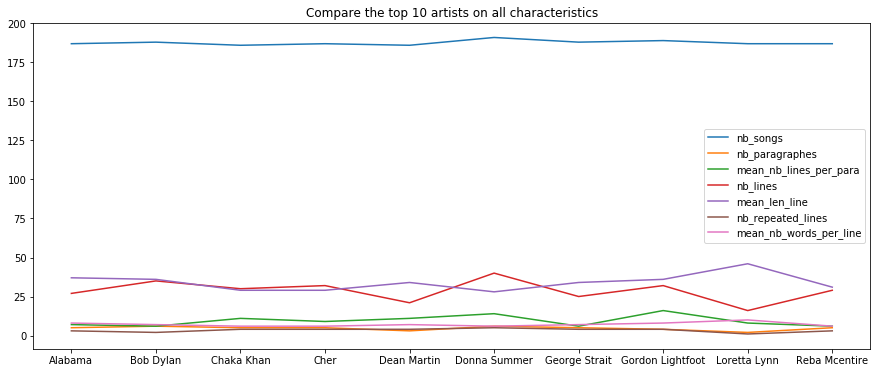

In [43]:
plt.figure(figsize=(15, 6))
topk = 10
artists = get_topk(topk, df)
plot_artists_to_show = artists_df[artists_df.index.isin(artists)]
df2 = plot_artists_to_show.drop(columns=['len_text'])
plt.plot(df2)
plt.legend(df2.columns)
plt.title("Compare the top {} artists on all characteristics".format(topk))

Text(0.5, 1.0, 'Compare all artists on all characteristics')

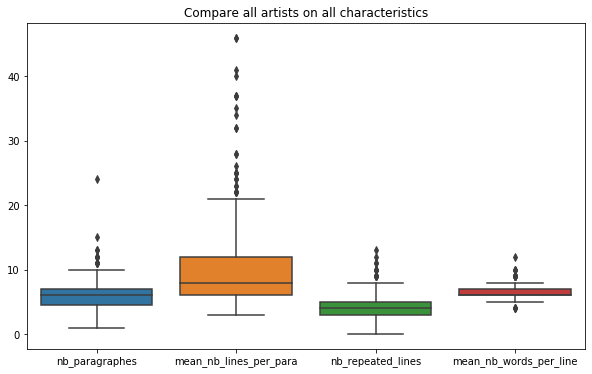

In [45]:
plt.figure(figsize=(10, 6))
df_plot = artists_df
sns.boxplot(data=df_plot.drop(columns=['nb_lines','mean_len_line','len_text','nb_songs']))
plt.title("Compare all artists on all characteristics")

# 1. Text pre-processing 

In [0]:
def preprocess(text, for_ghostwriter=False):
   
    if (for_ghostwriter==False):
      # Avoid having \n glued to a word (\n\n separations are used for ghostwriter)
      text = text.replace("\n"," \n ")
    text = text.lower()
    
    # Remove all words in-between () or []
    text = re.sub("[\(\[].*?[\)\]]", "", text)
   
    # Remove unwanted words
    unwanted_words = ['chorus\s*', 'verse\s*', 'intro\s*', 'outro\s*', 'bridge\s*','pre-chorus\s*','hook\s*', 'instrumental']
    text = re.sub('({})'.format('|'.join(unwanted_words)),"",text.strip())
    
    # Remove numbers
    text = re.sub(r'[0-9\.]+', '', text)

    # Only keep one space everywhere
    text = re.sub(' {2,}', ' ', text)

    # Remove some punctuation
    punct_to_keep = ["'","!","?",","]
    text = text.replace("?"," ? ")
    text = text.replace("!"," ! ")
    punct_to_discard = [x for x in string.punctuation if x not in punct_to_keep]
    text = "".join(v for v in text if v not in punct_to_discard)

    print ("Text length after preprocessing is : ", len(text))
    return text

def extract_characters(text):
    return sorted(list(set(text)))

def get_chars_index_dicts(chars):
    return dict((c, i) for i, c in enumerate(chars)), dict((i, c) for i, c in enumerate(chars))

def extract_words(text):
    # Split by space
    words = text.split(' ')
    word_counts = Counter(words)
    return sorted(word_counts, key=word_counts.get, reverse=True)

def get_words_index_dicts(sorted_vocab):
  return dict((c, i) for i, c in enumerate(sorted_vocab)), dict((i, c) for i, c in enumerate(sorted_vocab))

In [0]:
def preprocess_ghostwriter(text):
  """Add helpers such as <endline> and <endsong> to help model distinguish rhymes
  Arguments:
  text: all songs of an artist """

  # Do usual preprocessing
  text = preprocess(text, True)
  # Split in songs
  songs = text.split('\n\n')[:-1]

  new_songs = []
  
  for s in songs:
    new_para = []
    # Split each song in paragraphes
    paragraphes = s.split('\n  \n')
    for p in paragraphes :
      new_lines=[]
      # Split each paragraphe in lines
      lines = p.split('\n')
      for l in lines :
        new_lines.append(l+" <endline> ")
      p = " ".join(new_lines)
      new_para.append(p + "<endverse> ")
      
    new_s = " ".join(new_para)
    new_songs.append("<startsong> "+new_s+"<endsong>")

  return " ".join(new_songs)

In [0]:
def unprocess_ghostwriter(text):
  """ Remove helpers to create normal string"""
  text = text.replace("<startsong>", "")
  text = text.replace("<endsong>", " \n")
  text = text.replace("<endline>", "\n")
  text = text.replace("<endverse>", "\n\n")
  text = re.sub(' {2,}', ' ', text)
  # replace multiple blank lines by only one
  text = re.sub(r'(\n\s*)+\n+', '\n\n', text)

  return text

In [0]:
#Example
# abba = df[df.artist=="ABBA"]
# abbatext = " ".join([x for x in abba.text])
# te = preprocess_ghostwriter(abbatext)
# print(unprocess_ghostwriter(te))

# 2. Vectorization

### 2. 1) One-hot encoding

In [0]:
#Encode characters in numbers
def vectorize(sentence, char_to_index):
  return np.array([char_to_index[char] for char in sentence])

#Project a batch of int_sequences in dim chars space
def one_hot_encode(sequences, chars):
    X = np.zeros((len(sequences), len(sequences[0]), len(chars)), dtype=int)
    for i, sentence in enumerate(sequences):
        for t, integer in enumerate(sentence):
            X[i, t, integer] = 1
    return X

### 2. 2) Word2vec

In [0]:
#TODO

# Data extraction : file to encoded

In [0]:
def get_data_from_file(train_file,artists_names=None,mtype="characters", embedding="one-hot", ghostwrite=False):
  
    df = pd.read_csv(train_file)
    
    #Select artist
    if artists_names :
      df = df[df.artist.isin(artists_names)]
    
    print("Number of songs : ", len(df.index))

    #Get text
    text = ' '.join([x for x in df.text])

    #Transform data
    if ghostwrite:
      text = preprocess_ghostwriter(text)
    else:
      text = preprocess(text)
    
    if mtype=="words":
        #Get words
        vocab = extract_words(text)

        #Get dictionnaries
        word_to_index, index_to_word = get_words_index_dicts(vocab)

        #Encode text
        encoded_text = vectorize(text.split(' '), word_to_index)
    
    else:
        #Get characters
        vocab = extract_characters(text)

        #Get dictionnaries
        char_to_index, index_to_char = get_chars_index_dicts(vocab)

        #Encode text
        encoded_text = vectorize(text, char_to_index)

    return vocab, encoded_text

# Create Batches

In [0]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''

    #print("arrr", arr)
    #print(len(arr))
    #print("seq length", seq_length)
    batch_size_total = batch_size * seq_length
    #print("batch size total", batch_size_total)
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    #print("nb batches", n_batches)

    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

# 3. Create Model class and train function

## 3. A) LSTM

In [0]:
class LSTM(nn.Module):
    ## Chars is actually a dict of chars or a dict of words, depending on input
    def __init__(self, chars, hidden_size=256, num_layers=2, drop_prob=0.5):
        super().__init__()
        self.chars = chars
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        # Define layers
        self.lstm = nn.LSTM(input_size=len(chars), hidden_size=hidden_size, num_layers=num_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_size, len(chars))

    def forward(self, x, hidden):
      
      # Hidden = h et c les états internes
      output, hidden = self.lstm(x, hidden)
      # Use dropout
      out = self.dropout(output)
      out = out.contiguous().view(-1, self.hidden_size)
      out = self.fc(out)
      
      return out, hidden
      
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        
        # Create two new tensors with sizes nb_layers x batch_size x hidden_size,
        # initialized to zero, for hidden state and cell state of LSTM
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size, dtype=int).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size,dtype=int).to(device))
        
        return hidden

## 3. B) Train function

Save model function

In [0]:
def save_model(model, model_name, optimizer, nb_epochs, mtype=None, ghostwrite=None):
  PATH = "../models/" + model_name + "_"+ str(mtype) + ".net"
  checkpoint = {'nb_epochs': nb_epochs,
                'model_type' : mtype, 
                'ghostwrite' : ghostwrite,
                'chars': model.chars,
                'hidden_size': model.hidden_size,
                'nb_layers': model.num_layers,
                'drop_prob': model.drop_prob,
                'model_state_dict': model.state_dict(),
                'tokens': model.chars,
                'optimizer_state_dict' : optimizer.state_dict()}
  torch.save(checkpoint, PATH)

In [0]:
def train(model, data, optimizer=torch.optim.Adam, batch_size=10, seq_length=40, nb_epochs=50, 
          lr=0.01, clip=5, val_frac=0.1, top_k=1, print_stats=True, saving_model=False, artist=None, mtype=None, ghostwrite=None):
  """ trains model on data and returns last version of model (after all epochs!!)"""
  model = model.to(device)
  model.train()
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optimizer(model.parameters(), lr=lr)
  

  # Track the avg training loss of all epochs
  avg_train_losses = []
  # Track the avg validation loss of all epochs
  avg_valid_losses = [] 
    
  # Create training and validation data
  val_index = int(len(data)*(1-val_frac))
  train_data, val_data = data[:val_index], data[val_index:]

  counter = 0

  for epoch in range(nb_epochs):

    # Track the training and validation loss as the model trains in this epoch
    train_losses = []
    valid_losses = []

    ###################
    # train the model #
    ###################
    
    # Initialize hidden state
    h = model.init_hidden(batch_size)

    for x, y in get_batches(data, batch_size, seq_length):

      counter+=1

      # One-hot encode our data and make them Torch tensors (only x data!!)  
      x = one_hot_encode(x, model.chars)
          
      inputs, targets = torch.from_numpy(x).float(), torch.from_numpy(y).float()
      inputs, targets = inputs.to(device), targets.to(device)
      
      # Creating new variables for the hidden state, otherwise
      # we'd backprop through the entire training history
      h = tuple([each.data.float() for each in h])
 
      model.zero_grad()
      output, h = model(inputs, h)
      loss = criterion(output, targets.view(batch_size*seq_length).long())
      loss.backward()
      
      # Gradient clipping
      nn.utils.clip_grad_norm_(model.parameters(), clip)

      optimizer.step()

      train_losses.append(loss.item())
    
    ######################    
    # validate the model #
    ######################

    model.eval()
    
    # Initialize hidden state
    val_h = model.init_hidden(batch_size)
    
    # Track tha validation accuracies calculated every epoch
    val_accuracies = []
    # To calculate validation accuracy
    correct = 0
    total = 0
    
    for x, y in get_batches(val_data, batch_size, seq_length):
        
        # One-hot encode our data and make them Torch tensors
        x = one_hot_encode(x, model.chars)

        inputs, targets = torch.from_numpy(x).float(), torch.from_numpy(y).float()
        
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data.float() for each in val_h])
      
        inputs, targets = inputs.to(device), targets.to(device)
        output, val_h = model(inputs, val_h)
        val_loss = criterion(output, targets.view(batch_size*seq_length).long())
        valid_losses.append(val_loss.item())
        
        # TODO: same way to get values
        #tp_top_char_or_word = get_int_next_token_topk_filtering(output, model.chars, top_k)
        #print("tp", tp_top_char_or_word.shape)
        
        #softmax to get probas
        p = F.softmax(output, dim=1).data
        p = p.cpu()
        p, top_char_or_word = p.topk(1)
        top_char_or_word = top_char_or_word.numpy().squeeze()
        array_targets = targets.view(batch_size*seq_length).detach().cpu().numpy()

        #number of correct values in the sequence predicted (for one whole batch)
        correct += (top_char_or_word == array_targets).sum()
        total+= len(top_char_or_word)
       
    # Calculate val accuracy for whole epoch    
    accuracy =  correct / total
    val_accuracies.append(accuracy)

    # reset to train mode after iterating through validation data
    model.train() 
    
    # For each epoch calculate average loss 
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    if print_stats:
      # For each epoch print training/validation statistics 
      print("Epoch: [{}/{}]".format(epoch+1, nb_epochs),
              "Step: [{}]".format(counter),
              "Loss: {:.4f}".format(train_loss),
              "Val Loss: {:.4f}".format(valid_loss),
            "Val accuracy: %.2f%%"%(accuracy*100))
    if saving_model:
      save_model(model, artist+ "_epoch" +str(epoch+1),optimizer, epoch+1, mtype, ghostwrite)
      print("Saved model at epoch " + str(epoch+1))

  return model, avg_train_losses, avg_valid_losses, val_accuracies

# 4. Instantiate model

## 4. A) Quick example

In [276]:
words, encoded_text = get_data_from_file("songdata.csv",["The Beatles"], "words")
model = LSTM(words,hidden_size=256)
model =model.float()

Number of songs :  178
Text length after preprocessing is :  160343


In [277]:
#Train the model
model, avg_train_losses, avg_valid_losses, val_accuracies = train(model, encoded_text, batch_size=30,
                                                                  seq_length=40, nb_epochs=10, lr=0.01)

AttributeError: ignored

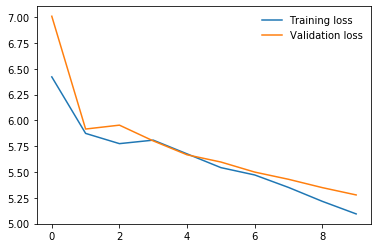

In [66]:
plt.figure()
plt.plot(avg_train_losses, label='Training loss')
plt.plot(avg_valid_losses, label='Validation loss')
plt.legend(frameon=False)

## 4. B) Create pipeline

In [0]:
def create_and_train_model(dict_chars_or_words, encoded_data, params, saving_model=False, mtype=None, print_stats=False):
    """ Function to facilitate creation and training of model """
    # 1. Create model
    model = LSTM(dict_chars_or_words,hidden_size=params['hidden_size'],
                 num_layers=params['nb_layers'], drop_prob=params['dropout']).float()

    # 2. Train model
    t = time.time()
    model, avg_train_losses, avg_valid_losses, val_accuracies = train(model, encoded_data, optimizer=params['optimizer'], 
                                                                      batch_size=params['batch_size'], seq_length=params['seq_length'], 
                                                                      nb_epochs=params['nb_epochs'], lr = params['learning_rate'],
                                                                      clip=params['clip'], val_frac=params['val_frac'],
                                                                      top_k = params[ 'top_k_sampling'], print_stats=print_stats, 
                                                                      saving_model=saving_model, artist=params['artists_names'], 
                                                                      mtype=mtype, ghostwrite = params['ghostwrite'])
    t = time.time() - t

    return model, avg_train_losses, avg_valid_losses, val_accuracies, t

In [0]:
def run_plot_save(params, print_stats=False):
    """ With a given dictionnary of parameters:
    - load data
    - create and train model
    - plot metrics and save graphs"""

    plt.ion() 

    # 1. Get data only once
    dict_chars_or_words, encoded_data = get_data_from_file(params['train_file'],[params['artists_names']], 
                                                           params['model_type'], params['embedding'],params['ghostwrite'])

    plt.figure(figsize=(10,4))
    
    # Args are our wanted parameters for each tested parameter
    args = {key : None for key in params.keys()}
    best_acc = 0
    accs = []
    number_of_model = 0
    
    for key in params.keys():
        if type(params[key]) != type(list()):
            args[key] = params[key]
    
    for key in params.keys():       
        
        if type(params[key]) == type(list()):
            for value in params[key]:
                
                # 2. Take the tested value to build and train model
                args[key] = value
                model, avg_train_losses, avg_valid_losses, val_accuracies, time = create_and_train_model(dict_chars_or_words, encoded_data, args, print_stats=print_stats)

                # Take last accuracy score / or avg ? / or max ?
                acc = val_accuracies[-1]
                accs.append(acc)
                number_of_model += 1
                
                if acc > best_acc:
                    best_acc, best_param, best_time = acc, value, time
                
                if key not in ['optimizer']:
                    str_value = str(value)
                else:
                    str_value = value.__name__

                print("Model {} : {} = {}, accuracy = {:.2f}%, training time = {:.2f} sec".format(number_of_model,key,str_value,acc*100,time))
                #plot train losses
                plt.plot(range(1,args['nb_epochs']+1), avg_train_losses, label="train_"+str_value)
                plt.plot(range(1,args['nb_epochs']+1), avg_valid_losses, label="val_"+str_value, linestyle='dashed')     
            
            if key not in ['optimizer']:
                x = [str(i) for i in params[key]]
            else:
                x = [value.__name__ for value in params[key]]
            
            # Visualization of val loss convergence
            plt.xlabel("number of epochs")
            plt.ylabel("train/val error")
            plt.legend(title=key)
            plt.title("Convergence of train/val loss")
            plt.savefig("../figures/"+ str(key) +"-train-val.png", metadata=params)

            # Visualization of accuracy per model
            plt.figure(figsize=(14,4))
            ax11=plt.subplot(1, 2, 1)
            accus = [100*acc for acc in accs]
            ax11.bar(x=x, height=accus)
            plt.xlabel(key)
            plt.ylabel("accuracy")
            plt.ylim([0.8*min(accs)*100,100])
            plt.title("Comparison of models' accuracy")
            plt.savefig("../figures/"+ str(key) +"-val-accuracy.png", metadata=params)

            # Performance of the best model
            print('Best {} : {}'.format(key,best_param))
            print('Accuracy of the best model on validation data: {:.2f} %'.format(best_acc*100))
            print('Training time of the best model: {:.2f} seconds'.format(best_time))
    
    plt.ioff()     
    
   

# 5. Hypertune model

## 5. A) Efficiency functions 

### **1) Similarity score**

In [0]:
def get_similarities(generated_song, other_songs):
  """Compute the "semantic" similarity between a generated song and a list of other_songs"""
  #Option A: Vectorizer direct
  tfidf_vectorizer = TfidfVectorizer()
  train_set= [generated_song]
  for song in other_songs:
      train_set.append(song)
  #print(len(train_set))
  tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_set)  #finds the tfidf score with normalization
  
  #Get similarity with first element = generated song
  similarities = cosine_similarity(tfidf_matrix_train[0], tfidf_matrix_train)

  return similarities

In [70]:
# Example
get_similarities(df.text[1],[df.text[0]])

array([[1.       , 0.1720383]])

Compute average song similarity for an artist's songs

In [0]:
def get_max_sim_artist(artist):
  """ Calculates the max similarity between all of an artist's songs"""
  max_similarities = []
  all_songs = df.text[df.artist==artist].reset_index(drop=True)
  for i in range(len(all_songs)-1):
    other_songs = all_songs[:i].tolist()+all_songs[i+1:].tolist()
    similarities = get_similarities(all_songs[i],other_songs)
    # Remove first element which is equal to one
    max_similarities.append(np.max(similarities[0][1:]))
  
  return np.max(max_similarities)
  

In [98]:
get_max_sim_artist("The Beatles")

0.9402929539591268

In [0]:
def get_max_similarity_score(generated_song,artist,df):
  """ Returns the maximum similarity between a generated song and all of an artists'songs""" 
  all_songs = df.text[df.artist==artist].reset_index(drop=True)
  similarities = get_similarities(generated_song,all_songs.tolist())
  # do not count first element which is one
  return np.max(similarities[0][1:])


In [0]:
#artists_df["mean_similarity"] = [get_mean_sim_artist(artist) for artist in artists_df.index]

### **2) Rhyme density**

In [0]:
def rhyme(input_word, level):
     """ Custome rhyming function that returns all words rhyming with input_word using the CMU dict from nltk
     - Level 1 : weak rhymes 
     - Level 2 : intermediate rhymes
     - Level 3 : strong rhymes """
     entries = nltk.corpus.cmudict.entries()
     syllables = [(word, syl) for word, syl in entries if word == input_word]
     rhymes = []
     for (word, syllable) in syllables:
             rhymes += [word for word, pron in entries if pron[-level:] == syllable[-level:]]
     return set(rhymes)

In [0]:
def compute_rhyme_density(lines, rhyming_function = rhyme, level = 2):
  """Compute the ratio of rhymes over number of lines"""
  """Rhyme function returns a dict with words rhyming :
  - pronoucing.rhymes : strong rhymes + does not count for same word
  - rhyme function : level 1 are the weakest rhymes and level 3 the strongest """
  nb_rimes = 0
  get_rimes = []
  counted_line_indexes = []
  splitted_lines = [line.split(" ") for line in lines]
  all_last_words = [normalize(x[-1]) for x in splitted_lines]
  # Compute words rhyming with unique last words only once
  rhyme_dict = get_rhyme_dict(np.unique(all_last_words), rhyming_function,level)
  for j in range(len(all_last_words)-2):
    #Only count lines in one rime maximum
    if j not in counted_line_indexes:
      # if rimes with next line
      if all_last_words[j] in rhyme_dict[all_last_words[j+1]]:
        nb_rimes +=1
        counted_line_indexes.extend([j,j+1])
        get_rimes.append((all_last_words[j], all_last_words[j+1]))
      # if rimes with 2 lines after
      elif all_last_words[j] in rhyme_dict[all_last_words[j+2]]:
        nb_rimes +=1
        counted_line_indexes.extend([j,j+2])
        get_rimes.append((all_last_words[j], all_last_words[j+2]))
  # Check for avant dernière ligne if nb_lines > 3
  if len(all_last_words)> 1:
    if len(all_last_words)-2 not in counted_line_indexes:
      if all_last_words[-2] in rhyme_dict[all_last_words[-1]]:
        nb_rimes +=1
        counted_line_indexes.extend([len(lines)-2,len(lines)-1])
        get_rimes.append((all_last_words[-2], all_last_words[-1]))
  #print(get_rimes)
  return nb_rimes/len(lines)


In [0]:
def get_rhyme_dict(unique_last_words, rhyming_function,level):
  """ Compute a dictionary {word: words riming with it} depending on rhyming function and level of rhyme"""
  rhyme_dict = {}
  if rhyming_function==pronouncing.rhymes:
    for word in unique_last_words:
      rhyme_dict[word] = rhyming_function(word)
  else:
    for word in unique_last_words:
      rhyme_dict[word] = rhyming_function(word,level) 
  return rhyme_dict


In [104]:
pronouncing.rhymes("fishing")

['dishing', 'phishing', 'wishing']

In [105]:
print("knitting" in rhyme("fishing",3))

False


In [106]:
# Test pronouncing lib (needs to be lower-case)
print("no" in pronouncing.rhymes("go"))
# Test cmu dict with rhyme function
print("candlelight" in rhyme("tonight",1))

True
True


In [0]:
# Example
#compute_rhyme_density(df.lines[1232],pronouncing.rhymes)
compute_rhyme_density(df.lines[1232])

0.4117647058823529

### **3) Grammar errors**

In [0]:
def count_grammar_errors(lines):
  """ Count the number of grammatical errors in lines of lyrics (input is a list)"""
  errors = []
  tool = language_check.LanguageTool('en-US')
  for line in lines :
     if len(tool.check(line)) > 0 :
       errors.extend(tool.check(line))
  
  errors_to_ignore = ['UPPERCASE_SENTENCE_START','I_LOWERCASE']
  real_errors = [e for e in errors if e.ruleId not in errors_to_ignore]

  #print(real_errors)
  return len(real_errors)

In [0]:
# Example
# print(df.text[122])
count_grammar_errors(df.lines[122])

1

In [128]:
artist = "Elton John"
one_artist_df = df[df.artist==artist].text.reset_index(drop=True)
count_grammar_errors(one_artist_df[0])

8

In [0]:
# This takes time
results = []
tp_artists = ["The Beatles"]
for a in tp_artists:
  x = []
  x.append(a)
  beatles = df[df.artist==a]
  x.append(np.mean(beatles.len_text))
  x.append(np.mean(beatles.nb_paragraphes))
  #x.append(np.mean(beatles.text.apply(compute_rhyme_density)))
  x.append(np.mean(beatles.text.apply(count_grammar_errors)))
  results.append(x)
results

[['The Beatles', 919.3932584269663, 5.848314606741573, 32.20786516853933]]

Compute rhyme density on 5 songs of the Beatles

In [256]:
beatles_lines = beatles_df.lines.reset_index(drop=True)
density = []
for i in range(0,5):
  density.append(compute_rhyme_density(beatles_lines[i]))
  print("done")

done
done
done
done
done


In [258]:
np.mean(density)

0.19043859649122807

## 5. B) Evaluate different impacts


In [0]:
flags = Namespace(
    train_file='songdata.csv',
    artists_names=['The Beatles']
)

### **1) Ghostwrite**

Ghostwrite

Number of songs :  178
Text length is :  155201


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model 1 : ghostwrite = True, accuracy = 72.65%, training time = 18.86 sec


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model 2 : ghostwrite = False, accuracy = 72.15%, training time = 18.80 sec
Best ghostwrite : True
Accuracy of the best model on validation data: 72.65 %
Training time of the best model: 18.86 seconds


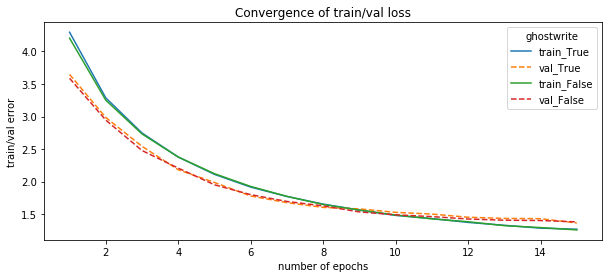

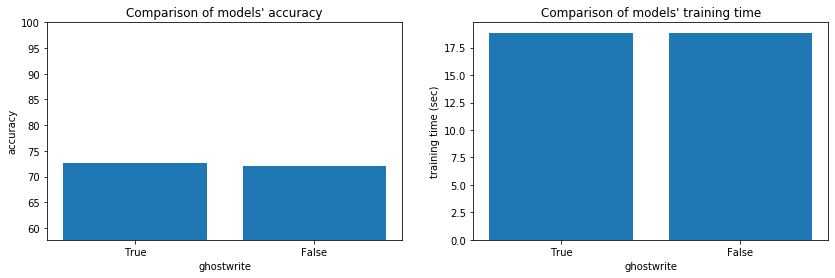

In [0]:
# Model = words
params = {'train_file':'songdata.csv',
          'model_type':"words",
          'artists_names':'The Beatles',
          'embedding' : 'one-hot',
          'ghostwrite' : [True,False],
          'nb_epochs' : 15,
          'nb_layers' : 1, 
          'seq_length' : 5,
          'batch_size' : 40,
          'hidden_size':256,
          'optimizer' : torch.optim.Adam,
          'learning_rate' : 0.01,
          'dropout':0.5,
          'clip':5,
          'val_frac':0.1,
          'top_k_sampling':5}

run_plot_save(params)


Pré-entrainé : **word2vec**

In [0]:
# TODO

### **2) Model's architecture** : words_LSTM


Number of songs :  120
Text length is :  110019


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model 1 : optimizer = Adam, accuracy = 69.17%, training time = 11.55 sec


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model 2 : optimizer = Adadelta, accuracy = 26.40%, training time = 12.02 sec


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model 3 : optimizer = Adagrad, accuracy = 45.83%, training time = 11.09 sec
Best optimizer : <class 'torch.optim.adam.Adam'>
Accuracy of the best model on validation data: 69.17 %
Training time of the best model: 11.55 seconds


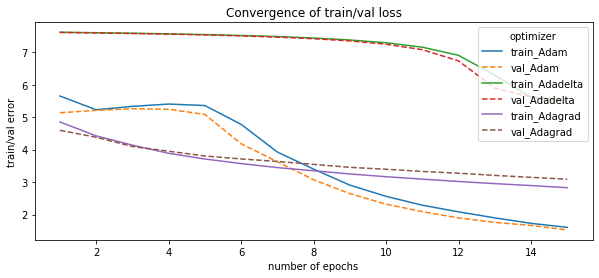

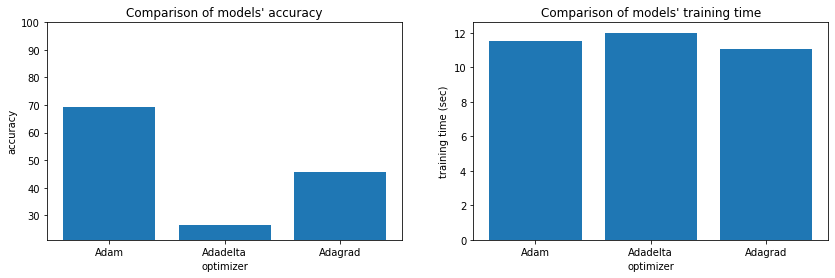

In [0]:
params = {'train_file':'songdata.csv',
          'model_type':"words",
          'artists_names':'The Beatles',
          'embedding' : 'one-hot',
          'ghostwrite' : True,
          'nb_epochs' : 15,
          'nb_layers' : 1, 
          #'nb_layers' : [1,2,3,4,5],
          'seq_length' : 15,
          'batch_size' : 40,
          #'batch_size' : [10,20,30,40,50,60], #usually not more than 120 examples
          'hidden_size':512,
          #'optimizer' : torch.optim.Adam,
          'optimizer' : [torch.optim.Adam, torch.optim.Adadelta,torch.optim.Adagrad],
          'learning_rate' : 0.01,
          #'learning_rate' : [0.1, 0.01, 0.05, 0.001],
          'dropout':0.0,
          'clip':5,
          'val_frac':0.2,
          'top_k_sampling':5}

run_plot_save(params)

### **3) Model's architecture** : chars_LSTM

Number of songs :  178
Text length after preprocessing is :  155201
Model 1 : seq_length = 5, accuracy = 78.87%, training time = 67.16 sec
Model 2 : seq_length = 10, accuracy = 80.77%, training time = 39.67 sec
Model 3 : seq_length = 15, accuracy = 79.16%, training time = 30.76 sec
Model 4 : seq_length = 20, accuracy = 78.19%, training time = 25.98 sec
Best seq_length : 10
Accuracy of the best model on validation data: 80.77 %
Training time of the best model: 39.67 seconds


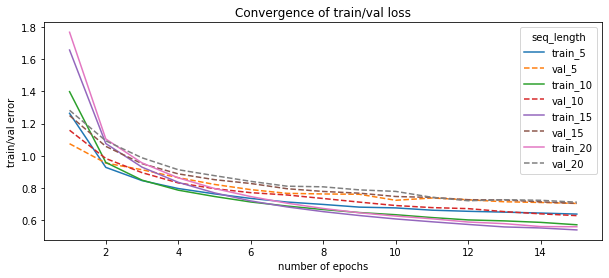

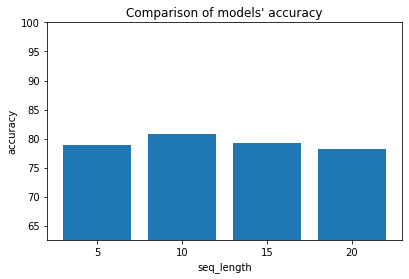

In [166]:
params = {'train_file':'songdata.csv',
          'model_type':"chars",
          'artists_names':'The Beatles',
          'embedding' : 'one-hot',
          'ghostwrite' : True,
          'nb_epochs' : 15,
          #'nb_epochs' : [10, 15, 30],
          'nb_layers' : 1, 
          #'nb_layers' : [1,2,3,4,5],
          #'seq_length' : 10,
          'seq_length' : [5, 10, 15, 20],
          'batch_size' : 40,
          #'batch_size' : [10,20,30,40,50,60], #usually not more than 120 examples
          'hidden_size':512,
          #'hidden_size' : [64,128,256,512],
          'optimizer' : torch.optim.Adam,
          #'optimizer' : [torch.optim.Adam, torch.optim.Adadelta,torch.optim.Adagrad],
          'learning_rate' : 0.01,
          #'learning_rate' : [0.1, 0.01, 0.05, 0.001],
          'dropout':0.0,
          'clip':5,
          'val_frac':0.2,
          'top_k_sampling':5}
run_plot_save(params)

# 6. Generate samples

## 6. A) Predict and sample functions

In [0]:
def predict(model, char_or_word, h=None, top_k=None, top_p=0.0, use_sampling=False):
        ''' Given a character/word, predict the next character/word.
            Returns the predicted character and the hidden state.
        '''
        # tensor inputs
        x = np.array([[model.char2int[char_or_word]]])
        x = one_hot_encode(x, model.chars)
        inputs = torch.from_numpy(x).float()
        
        inputs = inputs.to(device)
        
        # detach hidden state from history
        h = tuple([each.data.float() for each in h])
        
        # get the output of the model
        out, h = model(inputs, h)
        
        if use_sampling :
          temperature = 1
          out = out[0] / temperature
          filtered_logits = top_k_top_p_filtering(out, top_p=top_p, top_k=top_k)
          probabilities = F.softmax(filtered_logits, dim=-1)
          next_token = torch.multinomial(probabilities, num_samples=1)
          int_char_or_word = next_token.cpu().numpy()[0]

        else:
          # get the character probabilities
          p = F.softmax(out, dim=1).data
          
          p = p.cpu() # move to cpu
          
          # get top characters
          if top_k is None:
              top_ch = np.arange(len(model.chars))
          else:
              p, top_ch = p.topk(top_k)
              top_ch = top_ch.numpy().squeeze()
          
          # select the likely next character with some element of randomness
          p = p.numpy().squeeze()
    
          int_char_or_word = np.random.choice(top_ch, p=p/p.sum())
          
        #return the encoded value of the predicted char and the hidden state
        return model.int2char[int_char_or_word], h

In [0]:
def get_int_next_token_topk_filtering(output, chars, top_k):
    # get the character probabilities
    p = F.softmax(output, dim=1).data
    
    p = p.cpu() 
    
    # get top characters
    if top_k is None:
        top_ch = np.arange(len(chars))
    else:
        p, top_ch = p.topk(top_k)
        top_ch = top_ch.numpy().squeeze()
    
    # select the likely next character with some element of randomness
    p = p.numpy().squeeze()
    
    indices = np.arange(len(top_ch))
    index_char_or_word = np.random.choice(indices, p=p/p.sum())

    return top_ch[index_char_or_word]


In [0]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
     https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
    """
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

In [0]:
def sample(model, size, sentence='The', top_k=None,top_p=0.0, mtype="characters", ghostwrite=False, automatic_end=False, use_sampling=False):
    
    model = model.to(device)

    model.eval() # eval mode
    
    sentence = sentence.lower()

    if mtype=="words":
      list_words_or_chars = sentence.split(' ')
    else:
      list_words_or_chars = [char for char in sentence]
    
    h = model.init_hidden(1)
    
    for element in list_words_or_chars:
        new_element, h = predict(model, element, h, top_k=top_k,top_p=top_p,use_sampling=use_sampling)
    
    #add last one
    list_words_or_chars.append(new_element)
    
    # Pass in the previous element and get a new one until the end (fixed size or when created end song)
  
    if automatic_end:
      while True:
          new_element, h = predict(model, list_words_or_chars[-1], h, top_k=top_k,top_p=top_p,use_sampling=use_sampling)
          list_words_or_chars.append(new_element)
          if new_element == "<endsong>":
            unprocessed_output = ' '.join(list_words_or_chars)
            return unprocess_ghostwriter(unprocessed_output)
    else:
      for i in range(size):
        new_element, h = predict(model, list_words_or_chars[-1], h, top_k=top_k,top_p=top_p,use_sampling=use_sampling)
        list_words_or_chars.append(new_element)

    if mtype=="words":
      unprocessed_output = ' '.join(list_words_or_chars)
    else :
      unprocessed_output = ''.join(list_words_or_chars)
    
    if ghostwrite :
      return unprocess_ghostwriter(unprocessed_output)
    else:
      return unprocessed_output

## 6. B) Example 

In [153]:
params = {'train_file':'songdata.csv',
          'model_type':"words",
          'artists_names':'Coldplay',
          'embedding' : 'one-hot',
          'ghostwrite' : True,
          'nb_epochs' : 12,
          'nb_layers' : 1, 
          'seq_length' : 10,
          'batch_size' : 50,
          'hidden_size':512,
          'optimizer' : torch.optim.Adam,
          'learning_rate' : 0.01,
          'dropout':0.5,
          'clip':5,
          'val_frac':0.1,
          'top_k_sampling':5}


dict_chars_or_words, encoded_data = get_data_from_file(params['train_file'],flags.artists_names, 
                                                           params['model_type'], params['embedding'],params['ghostwrite'])
model, avg_train_losses, avg_valid_losses, val_accuracies, timing = create_and_train_model(dict_chars_or_words, encoded_data, 
                                                                                           params, saving_model=True, 
                                                                                           mtype=params["model_type"], print_stats=True)

Number of songs :  178
Text length after preprocessing is :  155201


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: [1/12] Step: [98] Loss: 4.6166 Val Loss: 5.0339 Val accuracy: 38.27%
Saved model at epoch 1
Epoch: [2/12] Step: [196] Loss: 3.5984 Val Loss: 3.2736 Val accuracy: 45.60%
Saved model at epoch 2
Epoch: [3/12] Step: [294] Loss: 3.0062 Val Loss: 5.6820 Val accuracy: 48.67%
Saved model at epoch 3
Epoch: [4/12] Step: [392] Loss: 2.7373 Val Loss: 2.3180 Val accuracy: 56.93%
Saved model at epoch 4
Epoch: [5/12] Step: [490] Loss: 2.1933 Val Loss: 2.0313 Val accuracy: 60.89%
Saved model at epoch 5
Epoch: [6/12] Step: [588] Loss: 1.9077 Val Loss: 1.8317 Val accuracy: 63.02%
Saved model at epoch 6
Epoch: [7/12] Step: [686] Loss: 1.7104 Val Loss: 1.6463 Val accuracy: 67.29%
Saved model at epoch 7
Epoch: [8/12] Step: [784] Loss: 1.5464 Val Loss: 1.5186 Val accuracy: 69.82%
Saved model at epoch 8
Epoch: [9/12] Step: [882] Loss: 1.4259 Val Loss: 1.4232 Val accuracy: 71.49%
Saved model at epoch 9
Epoch: [10/12] Step: [980] Loss: 1.3363 Val Loss: 1.3509 Val accuracy: 72.78%
Saved model at epoch 10

In [148]:
print(sample(model, 1000, sentence='<startsong>', top_k=40, mtype=params["model_type"],ghostwrite=params['ghostwrite'], automatic_end=True))

 when you told a girl who will love me 
 she feels good, she is she's so well i'm her 
 it's a long and lonely as 
 i don't know why you say goodbye, i say hello 
 i'm wondering why 
 i guess i'd try to make it shine, the velvet hand so i can't believe 
 oh ain't that i didn't 
 in a way place i look into my way 
 and when i, i wanna kiss you, yeah 
 i guess nobody ever really done me 
 so cry baby cry 




In [0]:
#print(sample(model, 1000, sentence='i\'ve come down', top_k=5))
#print(sample(imported_model, 1000, sentence='i\'ve come down', top_k=5))

## 7. C) Pipeline

In [0]:
def load_model(imported_model_name):
  """Load an already trained model"""
  PATH = "../models/" + imported_model_name + ".net"
  
  checkpoint = torch.load(PATH)

  imported_model = LSTM(checkpoint['chars'], checkpoint['hidden_size'], checkpoint['nb_layers'], checkpoint['drop_prob'])
  imported_model.load_state_dict(checkpoint['model_state_dict'])

  imported_model.eval()

  return imported_model, checkpoint['model_type'], checkpoint['ghostwrite'], checkpoint['optimizer_state_dict']

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [0]:
#imported_model, optim_state_dict = load_model("Coldplay_epoch9")

Option 1: Load an existing model and generate samples

In [0]:
def generate_save_samples(model, epoch, artist_name, nb_samples, sample_size, sentence_input, mtype, ghostwrite=None, automatic_end=None):
  """ with a created model and an artist name generate and save samples """
  for i in range(1, nb_samples+1):
    a_sample = sample(model, sample_size, sentence=sentence_input, top_k=5, mtype=mtype, ghostwrite=ghostwrite, automatic_end=automatic_end)
    name = artist_name + "_"+ mtype + "_"+ epoch+ "_sample" + str(i)
    text_file = open("../generated_lyrics/"+ name + ".txt", "w")
    text_file.write(a_sample)
    text_file.close()
  #print("Samples generated for", epoch)

In [0]:
def load_and_generate(model_name, nb_samples, sample_size, sentence_input, automatic_end=None, name_of_series=None):
  """ load an existing model and generate and save samples """
  model, model_type, ghostwrite, optim = load_model(model_name)
  artist_name = model_name.split("_")[0]
  epoch = model_name.split("_")[1]
  generate_save_samples(model, epoch, artist_name, nb_samples, sample_size, sentence_input, 
                        mtype=model_type, ghostwrite=ghostwrite, automatic_end=automatic_end)  

In [157]:
#Example 6B
load_and_generate("Coldplay_epoch12_words", 4, 1000, "i have", automatic_end=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Samples generated for epoch12


Option 2 : Create a model and generate/save samples

In [0]:
# 1. CREATE & TRAIN & SAVE MODEL
def generate_save_models(params, sample=False):
  """Function to create, train and save models at every epoch"""
  dict_chars_or_words, encoded_data = get_data_from_file(params['train_file'], [params['artists_names']], 
                                                           params['model_type'], params['embedding'],params['ghostwrite'])
  model, avg_train_losses, avg_valid_losses, val_accuracies, timing = create_and_train_model(dict_chars_or_words, encoded_data, params, 
                                                                                           saving_model=True, mtype=params['model_type'])
  if sample:
    return model, avg_train_losses, avg_valid_losses, val_accuracies, timing

In [0]:
# 2. LOAD MODELS AND GENERATE SAMPLES FOR EACH EPOCHS
def generate_samples_epochs(artists_name, model_type, nb_epochs, nb_samples_per_epoch, sample_size, sentence_input, automatic_end=None, name_of_series=None):
  """ For a model already trained, generate some samples for model saved at each epoch and evaluate it"""
  for epoch in range(1, nb_epochs+1):
    model_name = artists_name + "_epoch" + str(epoch) +"_" +model_type
    # Load model and generate samples
    load_and_generate(model_name, nb_samples_per_epoch, sample_size, sentence_input, 
                      automatic_end=automatic_end, name_of_series=name_of_series)
    print("Samples generated for epoch {}".format(epoch))
      

# 7. Samples' evaluation

## A) Evaluate samples

In [0]:
def simple_evaluate_sample(sample_name, rhyme_function = rhyme, level=2):
  with open("../generated_lyrics/"+ sample_name + ".txt", "r") as samplefile:
    data = samplefile.read()
  samplefile.close()
  artists_name = sample_name.split("_")[0]
  if len(data)>0:
    len_song = len(data)
    nb_paragraphes = data.count('\n\n')
    lines = get_lines(data)
    nb_words = get_nb_words(lines)
    nb_words_per_line = get_mean_nb_words_per_line(lines)
    nb_repeated_lines = get_nb_repeated_lines(lines)
    return len_song, nb_paragraphes, nb_words, nb_words_per_line, nb_repeated_lines
  return None, None, None

In [0]:
def evaluate_sample(sample_name, rhyme_function = rhyme, level=2):
  with open("../generated_lyrics/"+ sample_name + ".txt", "r") as samplefile:
    data = samplefile.read()
  samplefile.close()
  artists_name = sample_name.split("_")[0]
  if len(data)>0:
    len_song = len(data)
    nb_paragraphes = len(data.split('\n\n'))
    max_sim_score = get_max_similarity_score(data, artists_name,df)
    rhyme_density = compute_rhyme_density(get_lines(data), rhyme_function, level = level)
    nb_gram_errors = count_grammar_errors(get_lines(data))
    return len_song, nb_paragraphes, max_sim_score, rhyme_density, nb_gram_errors
  return None, None, None

In [0]:
def compare_samples(artists_name, model_type, start_epoch, end_epoch, nb_samples_per_epoch):
  """ For a model already trained, compare samples of all epochs"""
  len_songs = []
  nb_paragraphes_list = []
  #max_sim_scores = []
  #rhymes_densities = []
  #nb_gram_errorslist = []
  nb_words_per_line_list = []
  nb_words_list = []
  nb_repeated_lines_list = []
  for epoch in range(start_epoch, end_epoch+1):
    epoch_len_songs = []
    epoch_nb_paragraphes = []
    epoch_nb_words_per_line_list = []
    epoch_nb_words_list = []
    epoch_nb_repeated_lines_list = []
    # epoch_max_sim_scores = []
    # epoch_rhymes_densities = []
    # epoch_nb_gram_errorslist = []
    for sample in range(1, nb_samples_per_epoch+1):
        sample_name = artists_name + "_"+ model_type + "_epoch"+ str(epoch) + "_sample" +str(sample)
        len_song, nb_paragraphes, nb_words, nb_words_per_line, nb_repeated_lines = simple_evaluate_sample(sample_name)
        #len_song, nb_paragraphes, max_sim_score, rhyme_density, nb_gram_errors= evaluate_sample(sample_name)
        epoch_len_songs.append(len_song)
        epoch_nb_paragraphes.append(nb_paragraphes)
        epoch_nb_words_per_line_list.append(nb_words_per_line)
        epoch_nb_words_list.append(nb_words)
        epoch_nb_repeated_lines_list.append(nb_repeated_lines)
        # epoch_max_sim_scores.append(max_sim_score)
        # epoch_rhymes_densities.append(rhyme_density)
        # epoch_nb_gram_errorslist.append(nb_gram_errors)
        print("Epoch {}, Sample {} has been evaluated".format(epoch, sample))
      
    # Add mean values for samples of this epoch
    len_songs.append(np.mean(epoch_len_songs))
    nb_paragraphes_list.append(np.mean(epoch_nb_paragraphes))
    nb_words_per_line_list.append(np.mean(epoch_nb_words_per_line_list))
    nb_words_list.append(np.mean(epoch_nb_words_list))
    nb_repeated_lines_list.append(np.mean(epoch_nb_repeated_lines_list))
    # max_sim_scores.append(np.mean(epoch_max_sim_scores))
    # rhymes_densities.append(np.mean(epoch_rhymes_densities))
    # nb_gram_errorslist.append(np.mean(epoch_nb_gram_errorslist))
  
  return len_songs, nb_paragraphes_list, nb_words_per_line_list, nb_words_list, nb_repeated_lines_list
  #return len_songs, nb_paragraphes_list, max_sim_scores, rhymes_densities, nb_gram_errorslist


## B) Final pipeline for both models

### 1) word-LSTM

In [0]:
#Final parameters for words-LSTM
word_params = {'train_file':'songdata.csv',
          'model_type':"words",
          'artists_names':'The Beatles',
          'embedding' : 'one-hot',
          'ghostwrite' : True,
          'nb_epochs' : 50,
          #'nb_layers' : 1, 
          'nb_layers' : [1], 
          'seq_length' : 15,
          'batch_size' : 40,
          'hidden_size':512,
          'optimizer' : torch.optim.Adam,
          'learning_rate' : 0.01,
          'dropout':0.0,
          'clip':5,
          'val_frac':0.2,
          'top_k_sampling':5}

Number of songs :  178
Text length after preprocessing is :  155201
Epoch: [1/50] Step: [82] Loss: 4.7952 Val Loss: 4.1762 Val accuracy: 38.31%
Epoch: [2/50] Step: [164] Loss: 3.6785 Val Loss: 3.4429 Val accuracy: 45.66%
Epoch: [3/50] Step: [246] Loss: 2.9516 Val Loss: 2.8716 Val accuracy: 50.61%
Epoch: [4/50] Step: [328] Loss: 2.3895 Val Loss: 2.4042 Val accuracy: 55.05%
Epoch: [5/50] Step: [410] Loss: 1.9231 Val Loss: 2.1029 Val accuracy: 59.22%
Epoch: [6/50] Step: [492] Loss: 1.6128 Val Loss: 1.9061 Val accuracy: 62.08%
Epoch: [7/50] Step: [574] Loss: 1.3981 Val Loss: 1.7365 Val accuracy: 64.82%
Epoch: [8/50] Step: [656] Loss: 1.2329 Val Loss: 1.8150 Val accuracy: 63.28%
Epoch: [9/50] Step: [738] Loss: 1.1087 Val Loss: 1.6463 Val accuracy: 66.22%
Epoch: [10/50] Step: [820] Loss: 1.0068 Val Loss: 1.5309 Val accuracy: 67.96%
Epoch: [11/50] Step: [902] Loss: 0.9304 Val Loss: 1.4894 Val accuracy: 68.74%
Epoch: [12/50] Step: [984] Loss: 0.8608 Val Loss: 1.3935 Val accuracy: 70.32%
Epoch:

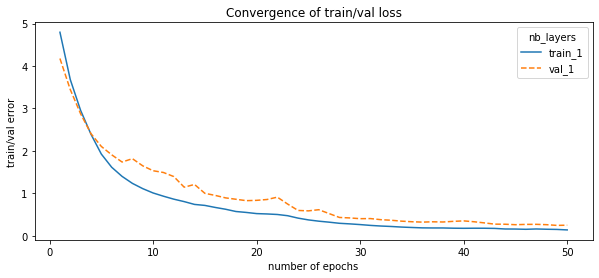

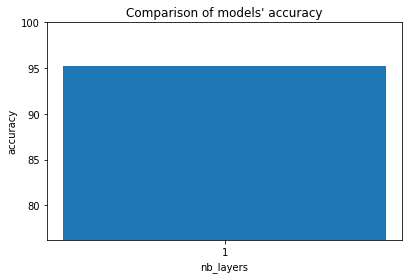

In [280]:
# Add bracket somewhere in params to make it work
run_plot_save(word_params, print_stats=True)

In [0]:
generate_save_models(word_params)

Number of songs :  178
Text length is :  155201
Saved model at epoch 1
Saved model at epoch 2
Saved model at epoch 3
Saved model at epoch 4
Saved model at epoch 5
Saved model at epoch 6
Saved model at epoch 7
Saved model at epoch 8
Saved model at epoch 9
Saved model at epoch 10
Saved model at epoch 11
Saved model at epoch 12
Saved model at epoch 13
Saved model at epoch 14
Saved model at epoch 15
Saved model at epoch 16
Saved model at epoch 17
Saved model at epoch 18
Saved model at epoch 19
Saved model at epoch 20
Saved model at epoch 21
Saved model at epoch 22
Saved model at epoch 23
Saved model at epoch 24
Saved model at epoch 25
Saved model at epoch 26
Saved model at epoch 27
Saved model at epoch 28
Saved model at epoch 29
Saved model at epoch 30
Saved model at epoch 31
Saved model at epoch 32
Saved model at epoch 33
Saved model at epoch 34
Saved model at epoch 35
Saved model at epoch 36
Saved model at epoch 37
Saved model at epoch 38
Saved model at epoch 39
Saved model at epoch 40
S

In [281]:
generate_samples_epochs("The Beatles", "words", 50, 1, 173, "<startsong>", automatic_end=True)

Samples generated for epoch 1
Samples generated for epoch 2
Samples generated for epoch 3
Samples generated for epoch 4
Samples generated for epoch 5
Samples generated for epoch 6
Samples generated for epoch 7
Samples generated for epoch 8
Samples generated for epoch 9
Samples generated for epoch 10
Samples generated for epoch 11
Samples generated for epoch 12
Samples generated for epoch 13
Samples generated for epoch 14
Samples generated for epoch 15
Samples generated for epoch 16
Samples generated for epoch 17
Samples generated for epoch 18
Samples generated for epoch 19
Samples generated for epoch 20
Samples generated for epoch 21
Samples generated for epoch 22
Samples generated for epoch 23
Samples generated for epoch 24
Samples generated for epoch 25
Samples generated for epoch 26
Samples generated for epoch 27
Samples generated for epoch 28
Samples generated for epoch 29
Samples generated for epoch 30
Samples generated for epoch 31
Samples generated for epoch 32
Samples generated

In [282]:
#len_songs, nb_paragraphes, max_sim_scores, rhymes_densities, nb_gram_errorslist = compare_samples("The Beatles", "words", 15, 20, 1)
len_songs, nb_paragraphes_list, nb_words_per_line_list, nb_words_list, nb_repeated_lines_list = compare_samples("The Beatles", "words", 1, 50, 1)

Epoch 1, Sample 1 has been evaluated
Epoch 2, Sample 1 has been evaluated
Epoch 3, Sample 1 has been evaluated
Epoch 4, Sample 1 has been evaluated
Epoch 5, Sample 1 has been evaluated
Epoch 6, Sample 1 has been evaluated
Epoch 7, Sample 1 has been evaluated
Epoch 8, Sample 1 has been evaluated
Epoch 9, Sample 1 has been evaluated
Epoch 10, Sample 1 has been evaluated
Epoch 11, Sample 1 has been evaluated
Epoch 12, Sample 1 has been evaluated
Epoch 13, Sample 1 has been evaluated
Epoch 14, Sample 1 has been evaluated
Epoch 15, Sample 1 has been evaluated
Epoch 16, Sample 1 has been evaluated
Epoch 17, Sample 1 has been evaluated
Epoch 18, Sample 1 has been evaluated
Epoch 19, Sample 1 has been evaluated
Epoch 20, Sample 1 has been evaluated
Epoch 21, Sample 1 has been evaluated
Epoch 22, Sample 1 has been evaluated
Epoch 23, Sample 1 has been evaluated
Epoch 24, Sample 1 has been evaluated
Epoch 25, Sample 1 has been evaluated
Epoch 26, Sample 1 has been evaluated
Epoch 27, Sample 1 ha

In [290]:
# COMPUTE ALL METRICS FOR ONE SAMPLE
sample_name = "The Beatles_words_epoch49_sample1"
with open("../generated_lyrics/"+ sample_name + ".txt", "r") as samplefile:
    generated_song = samplefile.read()
samplefile.close()
print("max score", get_max_similarity_score(generated_song,artist,df))
lines = get_lines(generated_song)
print("rhyme density", compute_rhyme_density(lines))
print("grammar errors", count_grammar_errors(lines))
print("song length", len(generated_song))
print("mean length of a line", get_mean_len_line(lines))
print("nb_paragraphes", generated_song.count("\n\n"))

max score 0.2278169351586046
rhyme density 0.1111111111111111
grammar errors 5
song length 607
mean length of a line 31
nb_paragraphes 3


In [291]:
np.mean(len_songs)

641.82

<function matplotlib.pyplot.show>

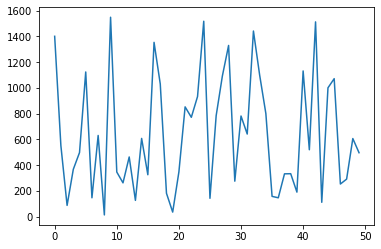

In [286]:
plt.plot(len_songs)
plt.show

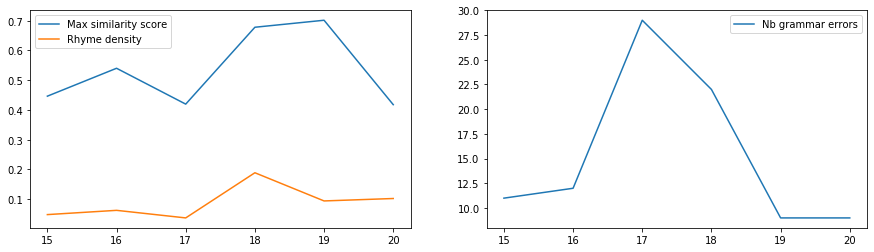

In [0]:
epochs = [i for i in range (15, 21)]
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(epochs, max_sim_scores, label="Max similarity score")
plt.plot(epochs, rhymes_densities, label= "Rhyme density")
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.plot(epochs, nb_gram_errorslist, label= "Nb grammar errors")
plt.legend(loc='best')
plt.show()

### 2) chars-LSTM

In [0]:
# Final parameters for chars-LSTM
chars_params = {'train_file':'songdata.csv',
          'model_type':"chars",
          'artists_names':'The Beatles',
          'embedding' : 'one-hot',
          'ghostwrite' : True,
          'nb_epochs' : 50,
          #'nb_layers' : 1, 
          'nb_layers' : [1],
          'seq_length' : 10,
          'batch_size' : 40,
          'hidden_size':512,
          'optimizer' : torch.optim.Adam,
          'learning_rate' : 0.01,
          'dropout':0.0,
          'clip':5,
          'val_frac':0.2,
          'top_k_sampling':5}

Number of songs :  178
Text length after preprocessing is :  155201
Epoch: [1/50] Step: [558] Loss: 1.4372 Val Loss: 1.2260 Val accuracy: 63.04%
Epoch: [2/50] Step: [1116] Loss: 0.9888 Val Loss: 1.0162 Val accuracy: 69.63%
Epoch: [3/50] Step: [1674] Loss: 0.8683 Val Loss: 0.9879 Val accuracy: 69.39%
Epoch: [4/50] Step: [2232] Loss: 0.7976 Val Loss: 0.8652 Val accuracy: 73.94%
Epoch: [5/50] Step: [2790] Loss: 0.7490 Val Loss: 0.8155 Val accuracy: 75.32%
Epoch: [6/50] Step: [3348] Loss: 0.7117 Val Loss: 0.7905 Val accuracy: 76.10%
Epoch: [7/50] Step: [3906] Loss: 0.6875 Val Loss: 0.7654 Val accuracy: 76.71%
Epoch: [8/50] Step: [4464] Loss: 0.6636 Val Loss: 0.7390 Val accuracy: 77.34%
Epoch: [9/50] Step: [5022] Loss: 0.6424 Val Loss: 0.7183 Val accuracy: 78.11%
Epoch: [10/50] Step: [5580] Loss: 0.6263 Val Loss: 0.7161 Val accuracy: 77.98%
Epoch: [11/50] Step: [6138] Loss: 0.6135 Val Loss: 0.6971 Val accuracy: 78.68%
Epoch: [12/50] Step: [6696] Loss: 0.6052 Val Loss: 0.6860 Val accuracy: 7

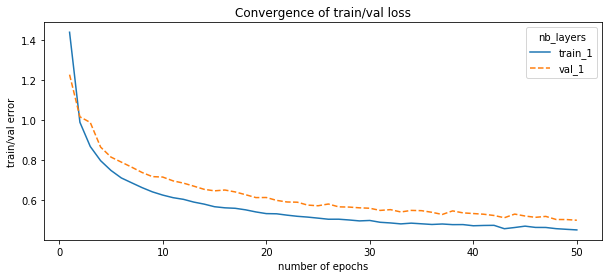

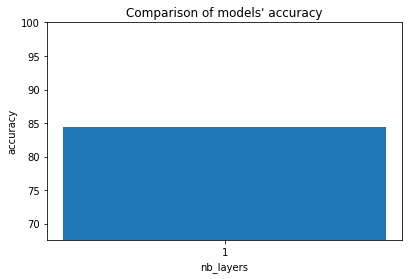

In [239]:
# Add bracket somewhere in params to make it work
run_plot_save(chars_params, print_stats=True)

In [181]:
generate_save_models(chars_params)

Number of songs :  178
Text length after preprocessing is :  155201
save model True
Saved model at epoch 1
save model True
Saved model at epoch 2
save model True
Saved model at epoch 3
save model True
Saved model at epoch 4
save model True
Saved model at epoch 5
save model True
Saved model at epoch 6
save model True
Saved model at epoch 7
save model True
Saved model at epoch 8
save model True
Saved model at epoch 9
save model True
Saved model at epoch 10
save model True
Saved model at epoch 11
save model True
Saved model at epoch 12
save model True
Saved model at epoch 13
save model True
Saved model at epoch 14
save model True
Saved model at epoch 15
save model True
Saved model at epoch 16
save model True
Saved model at epoch 17
save model True
Saved model at epoch 18
save model True
Saved model at epoch 19
save model True
Saved model at epoch 20
save model True
Saved model at epoch 21
save model True
Saved model at epoch 22
save model True
Saved model at epoch 23
save model True
Saved

In [269]:
generate_samples_epochs("The Beatles", "chars", 50, 1, 919, "<startsong>", automatic_end=False)

Samples generated for epoch 1
Samples generated for epoch 2
Samples generated for epoch 3
Samples generated for epoch 4
Samples generated for epoch 5
Samples generated for epoch 6
Samples generated for epoch 7
Samples generated for epoch 8
Samples generated for epoch 9
Samples generated for epoch 10
Samples generated for epoch 11
Samples generated for epoch 12
Samples generated for epoch 13
Samples generated for epoch 14
Samples generated for epoch 15
Samples generated for epoch 16
Samples generated for epoch 17
Samples generated for epoch 18
Samples generated for epoch 19
Samples generated for epoch 20
Samples generated for epoch 21
Samples generated for epoch 22
Samples generated for epoch 23
Samples generated for epoch 24
Samples generated for epoch 25
Samples generated for epoch 26
Samples generated for epoch 27
Samples generated for epoch 28
Samples generated for epoch 29
Samples generated for epoch 30
Samples generated for epoch 31
Samples generated for epoch 32
Samples generated

In [270]:
len_songs, nb_paragraphes_list, nb_words_per_line_list, nb_words_list, nb_repeated_lines_list = compare_samples("The Beatles", "chars", 1, 50, 1)

Epoch 1, Sample 1 has been evaluated
Epoch 2, Sample 1 has been evaluated
Epoch 3, Sample 1 has been evaluated
Epoch 4, Sample 1 has been evaluated
Epoch 5, Sample 1 has been evaluated
Epoch 6, Sample 1 has been evaluated
Epoch 7, Sample 1 has been evaluated
Epoch 8, Sample 1 has been evaluated
Epoch 9, Sample 1 has been evaluated
Epoch 10, Sample 1 has been evaluated
Epoch 11, Sample 1 has been evaluated
Epoch 12, Sample 1 has been evaluated
Epoch 13, Sample 1 has been evaluated
Epoch 14, Sample 1 has been evaluated
Epoch 15, Sample 1 has been evaluated
Epoch 16, Sample 1 has been evaluated
Epoch 17, Sample 1 has been evaluated
Epoch 18, Sample 1 has been evaluated
Epoch 19, Sample 1 has been evaluated
Epoch 20, Sample 1 has been evaluated
Epoch 21, Sample 1 has been evaluated
Epoch 22, Sample 1 has been evaluated
Epoch 23, Sample 1 has been evaluated
Epoch 24, Sample 1 has been evaluated
Epoch 25, Sample 1 has been evaluated
Epoch 26, Sample 1 has been evaluated
Epoch 27, Sample 1 ha

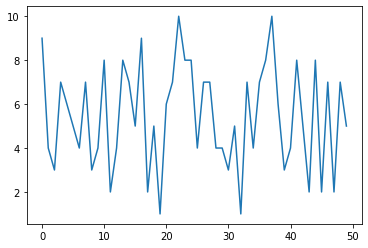

In [271]:
plt.plot(nb_paragraphes_list)

In [273]:
# COMPUTE ALL METRICS FOR ONE SAMPLE
sample_name = "The Beatles_chars_epoch50_sample1"
with open("../generated_lyrics/"+ sample_name + ".txt", "r") as samplefile:
    generated_song = samplefile.read()
samplefile.close()
print("max score", get_max_similarity_score(generated_song,artist,df))
lines = get_lines(generated_song)
print("rhyme density", compute_rhyme_density(lines))
print("grammar errors", count_grammar_errors(lines))
print("song length", len(generated_song))
print("mean length of a line", get_mean_len_line(lines))
print("nb_paragraphes", generated_song.count("\n\n"))

max score 0.36904291778138965
rhyme density 0.0
grammar errors 8
song length 635
mean length of a line 26
nb_paragraphes 3
